# Training - Cornell Dataset

## Imports

In [3]:
from tensorflow.keras import regularizers, layers, losses, preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from processing.helper_fxns import remove_url, clean_text
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
import pandas as pd
import numpy as np
import os, shutil
import string
import nltk
import sys
import re

import pydot

## Checking GPU

In [4]:
if tf.test.gpu_device_name():
  print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
  print('Please install GPU version of TF')

Default GPU Device: /device:GPU:0


2022-11-06 11:45:43.247315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-06 11:45:43.247334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-06 11:45:43.247459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-06 11:45:43.247466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Loading the Datasets

In [44]:
cornell_neutral = pd.read_csv("/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/datasets/initial/cornell_1500_neutral.csv")
cornell_neutral.head()

,text,sentiment
0,the terrorist must destroy any genetic remains...,neut
1,but later that year she was gunned down by ass...,neut
2,fourteen-year-old misfit farm boy duncan midge...,neut
3,a woman who again is able to let love into her...,neut
4,thornton stars as a man who is free after serv...,neut


In [45]:
cornell_neutral['sentiment'] = cornell_neutral['sentiment'].replace({'neut':1})
cornell_neutral['sentiment'].value_counts()

1    1500
Name: sentiment, dtype: int64

In [5]:
df = pd.read_csv('datasets/initial/cornell_v2_combined.csv')
df.head()

,text,sentiment
0,assume nothing . the phrase is perhaps one of...,2
1,plot : derek zoolander is a male model . he i...,2
2,i actually am a fan of the original 1961 or so...,2
3,a movie that's been as highly built up as the ...,2
4,""" good will hunting "" is two movies in one : ...",2


In [86]:
#test_data = pd.read_csv('datasets/initial/combined.csv')
test_data = pd.read_csv('datasets/initial/crawled_testset_final.csv')
print(test_data.shape)
test_data.head()

(800, 2)


,title,verdict
0,The difference between new and old padding in ...,1
1,me n my friend have vry sexual convos (will me...,1
2,Went for a dentist appointment for some pain a...,1
3,Why did I text someone again?,1
4,GUYS WE HAVE AN ACE CHARACTER AND HES A POC ð...,1


In [46]:
#concat

final_cornell_v2_neutral = pd.concat([df, cornell_neutral])
final_cornell_v2_neutral.head()

,text,sentiment
0,assume nothing the phrase perhaps one the most...,2
1,plot derek zoolander male model also very dumb...,2
2,actually fan the original liveactiondisney fli...,2
3,movie thats been highly built the truman show ...,2
4,good will hunting two movies one independent t...,2


In [88]:
df = final_cornell_v2_neutral
df['sentiment'].value_counts()

1    1500
2    1100
0    1100
Name: sentiment, dtype: int64

## Preprocessing

### Helper Functions to Remove URL and Clean Text

Importing the remove_url and clean_text fucntions to remove any URL in the text and to remove punctuations in the text.

In [89]:
df['text'] = df['text'].apply(remove_url)
df['text'] = df['text'].apply(clean_text)

test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)

In [90]:
print("Number of texts in each of the Classes in Training Set: ")
df['sentiment'].value_counts()

Number of texts in each of the Classes in Training Set: 


1    1500
2    1100
0    1100
Name: sentiment, dtype: int64

In [91]:
print("Number of texts in each of the Classes in Test Set: ")
test_data['sentiment'].value_counts()

Number of texts in each of the Classes in Test Set: 


1    500
2    150
0    150
Name: sentiment, dtype: int64

## Tokenization

Updates a list on vocabulary based on the text. It kind of creates its Vocabulary. This is important before converting texts into sequences. 

In [92]:
#Instantiating Tokenizer on Cornell and Crawled Dataset
num_words = 1000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(df['text'].tolist())
tokenizer.fit_on_texts(test_data['text'].tolist())

### Splitting Training Sets into Different Splits

In [93]:
NUM_TRAIN = int(0.8 * len(df))
NUM_VALID = int(0.2 * len(df))

In [94]:
#Prior to splitting
print(f"Length of dataset: {len(df)}")
print(f"Length of Train: {NUM_TRAIN}")
print(f"Length of Valid: {NUM_VALID}")
print(f"Length of Test: {len(test_data)}")

Length of dataset: 3700
Length of Train: 2960
Length of Valid: 740
Length of Test: 800


In [55]:
#splitting into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(df['text'].tolist(), 
                                                  df['sentiment'].tolist(), 
                                                  test_size=0.2, stratify=df['sentiment'].tolist(),
                                                  random_state=0)

In [95]:
X_test = test_data['text'].tolist()
y_test = test_data['sentiment'].tolist()

In [96]:
print(f"Length of Train : {len(X_train)}")
print(f"Length of Valid : {len(X_valid)}")
print(f"Length of Test : {len(X_test)}")

Length of Train : 2960
Length of Valid : 740
Length of Test : 800


In [97]:
#getting the class distribution
print("Class Distributions:")
print(f"Train: {str(Counter(y_train))}")
print(f"Valid: {str(Counter(y_valid))}")
print(f"Test: {str(Counter(y_test))}")

Class Distributions:
Train: Counter({1: 1200, 0: 880, 2: 880})
Valid: Counter({1: 300, 2: 220, 0: 220})
Test: Counter({1: 500, 2: 150, 0: 150})


### Converting Texts to Sequences and Storing them in Arrays

Assigning an index to each word in the text sample. Do note that for the Tokenization, 0 is not assigned to any word, it is instead assigned to any new/unknown word that is not present in the vocabulary.

In [98]:
#Converts the texts to sequences and stores it in an array
x_train = np.array(tokenizer.texts_to_sequences(X_train))
x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
x_test = np.array(tokenizer.texts_to_sequences(X_test))

/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1965/3986626980.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(tokenizer.texts_to_sequences(X_train))
/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1965/3986626980.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1965/3986626980.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of 

## Padding the Sequences

### Finding the Longest Word Sequence

This is important as this kind of defines what the shape of the input should be.

In [99]:
#finding the longest word sequence
train_num_words_text = pd.DataFrame(X_train, columns=['text'])['text'].apply(lambda x:len(str(x).split()))
max_len_train = max(train_num_words_text)

valid_num_words_text = pd.DataFrame(X_valid, columns=['text'])['text'].apply(lambda x:len(str(x).split()))
max_len_valid = max(valid_num_words_text)

test_num_words_text = pd.DataFrame(X_test, columns=['text'])['text'].apply(lambda x:len(str(x).split()))
max_len_test = max(test_num_words_text)

print('Longest Sentence in terms of words in Train: ', max_len_train)
print('Longest Sentence in terms of words in Valid: ', max_len_valid)
print('Longest Sentence in terms of words in Test: ', max_len_test)

Longest Sentence in terms of words in Train:  1880
Longest Sentence in terms of words in Valid:  1466
Longest Sentence in terms of words in Test:  43


Therefore, in order to account for the all the splits, we set the shape of the input as 1885.

In [61]:
MAXLEN = 1885

In [100]:
x_train = pad_sequences(x_train, padding='post', maxlen=MAXLEN)
x_valid = pad_sequences(x_valid, padding='post', maxlen=MAXLEN)
x_test = pad_sequences(x_test, padding='post', maxlen=MAXLEN)

In [63]:
x_train[0]

array([230,   1,  78, ...,   0,   0,   0], dtype=int32)

In this section, we extended the list of the sequences to the MAXLEN, in order to standardise across te splits.

## Encoding the Labels

In [101]:
#Instantiating the LabelEncoder
le = LabelEncoder()

In [102]:
#Encoding the train labels
train_labels = le.fit_transform(y_train)
valid_labels = le.transform(y_valid)
test_labels = le.transform(y_test)

#Converting the encoded train labels into categorical form and then storing them as an array
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

In [67]:
#Listing out the classes
list(le.classes_)

[0, 1, 2]

0 - neg , 1 - neut, 2 - pos
[neg neut pos]

In [103]:
test_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Creating our own Tensorflow Dataset

In [104]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [105]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor([230   1  78 ...   0   0   0], shape=(1885,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
======Validation dataset ====
tf.Tensor([2 1 1 ... 0 0 0], shape=(1885,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
======Test dataset ====
tf.Tensor([  2   1 122 ...   0   0   0], shape=(1885,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


## CNN Model Creation

In [71]:
#Initialsing Parameters
max_features = 1000
vocab_size = 1000
embedding_dim = 64
sequence_length = MAXLEN
epochs = 100
batch_size = 32
filters = 32
kernel_size = 3
hidden_dims = 250
#epochs = 10

In [72]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length, embeddings_regularizer = regularizers.l2(0.0005)))
model.add(tf.keras.layers.Conv1D(128,3, activation='relu', kernel_regularizer = regularizers.l2(0.0005),bias_regularizer = regularizers.l2(0.0005)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=['CategoricalAccuracy'])

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1885, 64)          64064     
_________________________________________________________________
conv1d (Conv1D)              (None, 1883, 128)         24704     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 89,155
Trainable params: 89,155
Non-trainable params: 0
____________________________________________________

In [74]:
#creating callbacks - early stopping and storing best model checkpoint 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=10)

checkpoint_filepath = '/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/weights/cornell_v2_best_epoch{epoch}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'val_categorical_accuracy',
    save_best_only=True)

In [75]:
#compiling the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])


## Training

In [76]:
history = model.fit(train_ds.shuffle(1000).batch(128),
                    epochs=epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])
model.save('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/models/cornell_v2_final_model.h5')

Epoch 1/100


/Users/sankeerthana/miniforge3/envs/ml/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4882: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2022-11-06 11:55:08.885796: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-06 11:55:08.886677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 1.1365 - categorical_accuracy: 0.4645

2022-11-06 11:55:29.159085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 21s 831ms/step - loss: 1.1365 - categorical_accuracy: 0.4645 - val_loss: 1.0676 - val_categorical_accuracy: 0.4838
Epoch 2/100
24/24 [==============================] - 22s 904ms/step - loss: 0.9934 - categorical_accuracy: 0.6361 - val_loss: 0.8686 - val_categorical_accuracy: 0.6878
Epoch 3/100
24/24 [==============================] - 22s 898ms/step - loss: 0.7978 - categorical_accuracy: 0.6905 - val_loss: 0.7032 - val_categorical_accuracy: 0.6770
Epoch 4/100
24/24 [==============================] - 21s 889ms/step - loss: 0.6990 - categorical_accuracy: 0.7061 - val_loss: 0.6493 - val_categorical_accuracy: 0.7743
Epoch 5/100
24/24 [==============================] - 21s 887ms/step - loss: 0.6631 - categorical_accuracy: 0.7166 - val_loss: 0.6251 - val_categorical_accuracy: 0.7784
Epoch 6/100
24/24 [==============================] - 22s 894ms/step - loss: 0.6413 - categorical_accuracy: 0.7284 - val_loss: 0.6139 - val_categorical_accuracy: 0.7351
Epoc

**Try 1**

Model stopped at epoch 30 - with val_categorical_accuracy = 0.7975

### Storing the History File - Future References

In [77]:
with open('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/history/cornell_v2_history.txt', 'w') as f:
    f.writelines(str(history.history))

### Saving Model Code

In [98]:
model_code = ["model = tf.keras.Sequential()",
"model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length, embeddings_regularizer = regularizers.l2(0.0005)))", 
"model.add(tf.keras.layers.Conv1D(128,3, activation='relu', kernel_regularizer = regularizers.l2(0.0005),bias_regularizer = regularizers.l2(0.0005))) ",                             
"model.add(tf.keras.layers.GlobalMaxPooling1D())",
"model.add(tf.keras.layers.Dropout(0.5))",
"model.add(tf.keras.layers.Flatten())",
"model.add(tf.keras.layers.Dense(2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))",
"model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=['CategoricalAccuracy'])"]

In [99]:
with open('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/models/try1_model_code.txt','w') as f:
    f.writelines(str(model_code))

## Performance Visualisation and Analysis

### Accuracy Curves

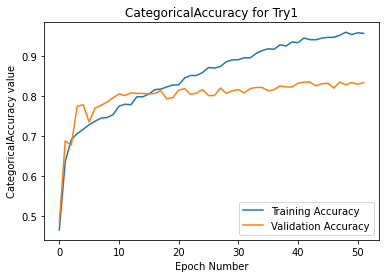

In [78]:
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('CategoricalAccuracy for Try1')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('Epoch Number')
plt.legend(loc="lower right")
plt.savefig('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/analysis/cornell_v2__acc.jpg')
plt.show()

### Loss Curves

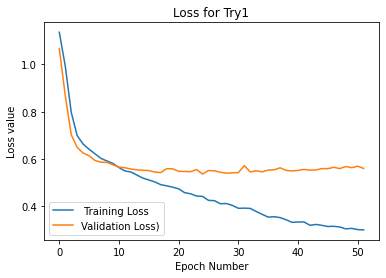

In [79]:
plt.plot(history.history['loss'], label=' Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss)')
plt.title('Loss for Try1')
plt.ylabel('Loss value')
plt.xlabel('Epoch Number')
plt.legend(loc="lower left")
plt.savefig('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/analysis/cornell_v2_try2_loss.jpg')
plt.show()

## Inference on Test Set

### Predictions

In [106]:
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples


2022-11-06 18:35:45.787835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.01189631 0.9732666  0.01483711]
 [0.15062359 0.68962127 0.1597552 ]
 [0.12916745 0.06832042 0.80251217]
 ...
 [0.06960411 0.883766   0.0466299 ]
 [0.12995091 0.5324104  0.33763868]
 [0.02311238 0.93603605 0.04085155]]


In [107]:
test_data['pred_sentiment'] = predict_results

In [108]:
test_data

,text,sentiment,pred_sentiment
0,the difference between new and old padding bus...,1,1
1,friend have vry sexual convos will mention the...,1,1
2,went for dentist appointment for some pain aft...,1,2
3,why did text someone again,1,1
4,guys have ace character and hes poc ððð...,1,1
...,...,...,...
795,ive made decision that will quite possibly mos...,0,1
796,hate anxiety,0,1
797,lesbian but too afraid tell anyone,0,1
798,not enough and dont think that ever will,0,1


### Score

In [109]:
gt_label = test_data['sentiment']
pred_label = test_data['pred_sentiment']

In [110]:
correct = 0
wrong = 0

for i in range(len(gt_label)):
    if gt_label[i] == pred_label[i]:
        correct += 1
    else:
        wrong += 1

print("========= RESULT ==========")
print(f"Total : {len(gt_label)}")
print(f"Correct : {correct}")
print(f"Wrong : {wrong}")

print("")

print(f"Accuracy : {(correct/len(gt_label))*100}")

========= RESULT ==========
Total : 800
Correct : 465
Wrong : 335

Accuracy : 58.12500000000001


Accuracy on Test Set is 58.1%

In [111]:
val = [0, 1, 2]
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=val))

              precision    recall  f1-score   support

           0       0.22      0.07      0.11       150
           1       0.63      0.89      0.74       500
           2       0.18      0.05      0.07       150

    accuracy                           0.58       800
   macro avg       0.34      0.34      0.31       800
weighted avg       0.47      0.58      0.50       800

